### Justin Butler
### Population Project
### USA Data

c =  -0.0234540094056
d =  -0.634720038359


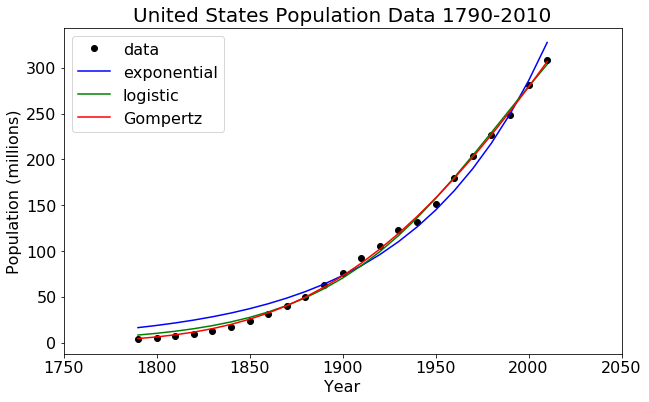

expR2 =  0.985918115979
logR2 =  0.997520321806
gompR2 =  0.999028317321
Adjusted Exp R2 =  0.984509927577
Adjusted Log R2 =  0.997128793671
Adjusted Gomp R2 =  0.99887489374

Exp P0 = 327.783072118
 Exp r = 0.0136356319963

Log P0 = 303.819041867
 Log r = 0.0207764366954
 Log L = 486.47534526

Gom P0 = 306.897916941
 Gom r = 0.00608489971242
 Gom L = 1389.52467514
 

For the following values of 2010, I eliminated the data point for 2010 and recalculated the models
for that year. The values were then compared by using the error function:

 Exponential 
Exponential estimation for 2010: 341.4
Error from actual value of 2010: 10.59%

 Logistic 
   Logistic estimation for 2010: 297.0
Error from actual value of 2010: 3.81%

 Gompertz 
   Gompertz estimation for 2010: 304.8
Error from actual value of 2010: 1.29%


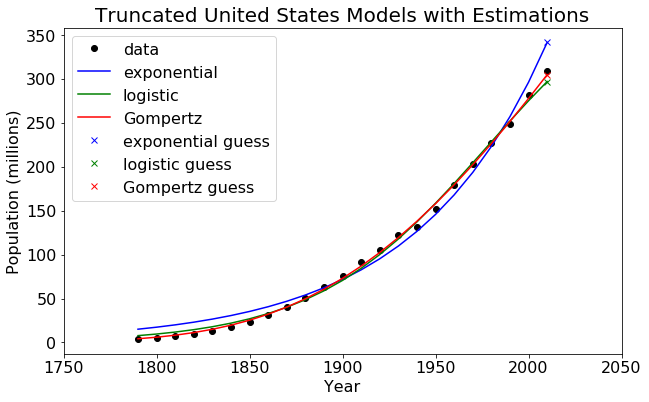

In [3]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#This class can be called to alter the text of a printed line
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


#--------------------------------------------------
# Read and scale US Population Data.
#--------------------------------------------------
CensusFile = open('USPopulation.csv', 'r') #Don't you dare overwrite this file!
N = 23 # number of data points
i = 0
j = 0
USYears = np.zeros([N], dtype=int)
USPop0 = np.zeros([N], dtype=int)
for line in CensusFile:
    if i == 0 or i==1:
        i=i+1
    else:
        values = line.split(',')
        USYears[j] = int(values[0])
        USPop0[j] = int(values[1])
        j = j+1
        i = i+1

CensusFile.close()
USPop = USPop0/1.e6 #population as a floating point number in millions

#----------------------------------
# Find the PPGR and PolyFit values
#----------------------------------

#Declare the array to store my PPGR values
M = N-2 #number of data points - since the two end points aren't between two points
PPGR = np.zeros([M])

#This for loop will find the PPGR between any two points with one point between them.
for k in range(21):
    PPGR[k] =  (1/USPop[k+1])*((USPop[k+2]-USPop[k])/(USYears[k+2]-USYears[k]))
    k = k+1

#Caluculate the average of all of the values just generated
avgPPGR = np.average(PPGR)

#Time to start making the best fit line. First we will use np.polyfit to find the slope and y-intercept of the line
USPopLineCoef = np.polyfit(USPop[1:N-1],PPGR,1)

#If something seems weird, uncomment the next line to view the line coefficients
#print (USPopLineCoef)

#Next, I will use the values of USPop as my x-values for a function of the best fit line
USPopLine = USPopLineCoef[0]*USPop + USPopLineCoef[1]


#------------------------------------------------------------------------------------------
# Time to make the functions of our models
#------------------------------------------------------------------------------------------

#Exponential model
def US_exp(t,P0,r):
    P = P0*np.exp(r*t)
    return P

#Calculating L and r (estimates) for logistic model
#L = (-USPopLineCoef[1])/USPopLineCoef[0]
#r = USPopLineCoef[1]

#Logistic Model
def US_log(t,P0,r,L):
    A = ((L-P0)/P0)
    T = L
    B = 1 + A*np.exp(-r*t)
    return T/B

#Gompertz Model
def US_Gomp(t,P0,r,L):
    rG = np.exp(-r*t)
    log = np.log(L/P0)
    exp = -log*rG
    return L*np.exp(exp)

#---------------------------------
# Population graph
#---------------------------------

#plt.figure(figsize=(8,6))
#plt.rc('xtick', labelsize=16) 
#plt.rc('ytick', labelsize=16)
#
#plt.plot(USYears, USPop, 'o', color=('#32CD32'), label='data')
#plt.ylabel('Population (millions)', fontsize=16)
#plt.xlabel('Year', fontsize=16)
#plt.title('United States Population Data 1790-2010', fontsize=20)
#plt.legend(loc=2, fontsize=16)
#plt.xlim([1750, 2050])
#plt.savefig('USPopData.png')
#plt.show()
#plt.close()

#----- Estimating the upper limit of the population, L ---------
L = 500

#----------------------
# Optimize Exponential
#----------------------

#------- Approximate parameter values for Exponential model ------
a,b = np.polyfit(USYears-2010,np.log(USPop),1)
#print "a =", a,"b =", b

r_exp_lin = a
P0_exp_lin = np.exp(b)

#------- Take estimate and create the model -------------

eopt, ecov = curve_fit(US_exp, USYears-2010, USPop, p0=(P0_exp_lin,r_exp_lin))
#print "popt =", popt, "pcov =", pcov

P_0exp = eopt[0]
r_exp = eopt[1]
P_exp = US_exp(USYears-2010, P_0exp, r_exp)

#----------------------
# Optimize Logistic
#----------------------

#------- Approximate paramater values for Logistic model ---------
c,d = np.polyfit(USYears-2010, np.log((L/USPop)-1),1)

print "c = ",c
print "d = ",d

r_log_lin = -c
P0_log_lin = L/(np.exp(d)+1)


#------- Take estimate and create logistic
lopt, lcov = curve_fit(US_log, USYears-2010, USPop, p0=(P0_log_lin,r_log_lin,L))
#print "lopt =", lopt, "lcov =", lcov

P_0log = lopt[0]
r_log = lopt[1]
L_log = lopt[2]
P_log = US_log(USYears-2010, P_0log, r_log, L_log)

#----------------------
# Optimize Gompertz
#----------------------

#------- Approximate parameter values for Gompertz model -----------
e,f = np.polyfit(USYears-2010,np.log(np.log(L/USPop)),1)

r_gomp_lin = -e
P_0gomp_lin = L*(np.exp(-np.exp(f)))

#print ("r_gom_lin =", r_gom_lin)
#print ("P_0gom_lin =", P_0gom_lin)

#------- Take estimate and create Gompertz --------
gopt, gcov = curve_fit(US_Gomp, USYears-2010, USPop, p0=(P_0gomp_lin, r_gomp_lin,L))
#print "gopt =", gopt
#print "gcov =", gcov

P_0gomp = gopt[0]
r_gomp = gopt[1]
L_gomp = gopt[2]
P_gomp = US_Gomp(USYears-2010, P_0gomp, r_gomp, L_gomp) 

#------------------------
# Plotting the Graphs
#------------------------

plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
#Plotting the data points
plt.plot(USYears, USPop, 'o', color='k', label='data')
#First, draw the exponential model,
plt.plot(USYears, P_exp, color='b', label='exponential')
#then the logistic model,
plt.plot(USYears, P_log, color='g', label="logistic")
#and finally Gompertz model.
plt.plot(USYears, P_gomp, color='r', label = 'Gompertz')
plt.ylabel('Population (millions)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('United States Population Data 1790-2010', fontsize=20)
plt.legend(loc=2, fontsize=16)
#plt.xlim([-250, 10])
plt.xlim([1750, 2050])
plt.savefig('USPopModel.png')
plt.show()
plt.close()

#-------------------------------------------------------------------
# Finding the Coefficients of Determination for these three models
#-------------------------------------------------------------------

#R squared (coefficient of determination) for Exponential
numsum = np.zeros([3])
densum = np.zeros([3])
for i in range(23): #For all of the data points
    for j in range(3): #For all three sets of data
        if j==0:
            numsum[j] = numsum[j] + (USPop[i]-US_exp(USYears[i]-2010, P_0exp, r_exp))**2
            densum[j] = densum[j] + (USPop[i]-np.average(USPop))**2
        elif j==1:
            numsum[j] = numsum[j] + (USPop[i]-US_log(USYears[i]-2010, P_0log, r_log,L_log))**2
            densum[j] = densum[j] + (USPop[i]-np.average(USPop))**2
        else:
            numsum[j] = numsum[j] + (USPop[i]-US_Gomp(USYears[i]-2010, P_0gomp, r_gomp,L_gomp))**2
            densum[j] = densum[j] + (USPop[i]-np.average(USPop))**2
    
expR2 = 1 - (numsum[0]/densum[0])
logR2 = 1 - (numsum[1]/densum[1])
gompR2 = 1 - (numsum[2]/densum[2])
#print "expR2 = ", expR2
#print "logR2 = ", logR2
print "gompR2 = ", gompR2

#Adjusted coefficients of determinations
expAR2 = 1. - (1. - expR2)*((23.-1.)/(23.-2.-1.))
logAR2 = 1. - (1. - logR2)*((23.-1.)/(23.-3.-1.))
gompAR2 = 1. - (1. - gompR2)*((23.-1.)/(23.-3.-1.))
print "Adjusted Exp R2 = ", expAR2
print "Adjusted Log R2 = ", logAR2
print "Adjusted Gomp R2 = ", gompAR2

# Print the values I need for my paper
print ""
print "Exp P0 =", P_0exp
print " Exp r =", r_exp
print ""
print "Log P0 =", P_0log
print " Log r =", r_log
print " Log L =", L_log
print ""
print "Gom P0 =", P_0gomp
print " Gom r =", r_gomp
print " Gom L =", L_gomp

#------------------------------------------------------------
# Working with predictions: Eliminating the last data point
#------------------------------------------------------------

print "",'\n',""
print "For the following values of 2010, I eliminated the data point for 2010 and recalculated the models"
print "for that year. The values were then compared by using the error function:"

USPopPast = USPop[0:N-1]
USYearsPast = USYears[0:N-1]

#--------------- Exponential Model -------------------
ep_opt, ep_cov = curve_fit(US_exp, USYearsPast-2000, USPopPast, p0=(P0_exp_lin,r_exp_lin))
#print "popt =", popt, "pcov =", pcov

P_0exp_past = ep_opt[0]
r_exp_past = ep_opt[1]
P_exp_past = US_exp(USYears- 2000, P_0exp_past, r_exp_past)

exp_est_2010 = US_exp(10, P_0exp_past, r_exp_past)
print ""
print color.BOLD, "Exponential", color.END
print "Exponential estimation for 2010:", round(exp_est_2010,1)
print "Error from actual value of 2010: {}%".format(round((np.absolute(exp_est_2010-USPop[22])/USPop[22])*100,2))

#---------------- Logistic Model ---------------------
lp_opt, lp_cov = curve_fit(US_log, USYearsPast-2000, USPopPast, p0=(P_0log, r_log, L_log))
#print "lopt =", lopt, "lcov =", lcov

P_0log_past = lp_opt[0]
r_log_past = lp_opt[1]
L_log_past = lp_opt[2]
P_log_past = US_log(USYears-2000, P_0log_past, r_log_past, L_log_past)

log_est_2010 = US_log(10, P_0log_past, r_log_past, L_log_past)
print ""
print color.BOLD, "Logistic", color.END
print "   Logistic estimation for 2010:", round(log_est_2010,1)
print "Error from actual value of 2010: {}%".format(round((np.absolute(log_est_2010-USPop[22])/USPop[22])*100,2))

#---------------- Gompertz Model ---------------------
gp_opt, gp_cov = curve_fit(US_Gomp, USYearsPast-2000, USPopPast, p0=(P_0gomp, r_gomp, L_gomp))
#print "gopt =", gopt
#print "gcov =", gcov

P_0gomp_past = gp_opt[0]
r_gomp_past = gp_opt[1]
L_gomp_past = gp_opt[2]
P_gomp_past = US_Gomp(USYears-2000, P_0gomp_past, r_gomp_past, L_gomp_past) 

gomp_est_2010 = US_Gomp(10, P_0gomp_past, r_gomp_past, L_gomp_past)
print ""
print color.BOLD, "Gompertz", color.END
print "   Gompertz estimation for 2010:", round(gomp_est_2010,1)
print "Error from actual value of 2010: {}%".format(round((np.absolute(gomp_est_2010-USPop[22])/USPop[22])*100,2))

#--------------------------------------------------------------
# Plotting the models with the omission, as well as predictions
#--------------------------------------------------------------

plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
#Plotting the data points
plt.plot(USYears, USPop, 'o', color='k', label='data')
#First, draw the exponential model,
plt.plot(USYears, P_exp_past, color='b', label='exponential')
#then the logistic model,
plt.plot(USYears, P_log_past, color='g', label="logistic")
#and finally Gompertz model.
plt.plot(USYears, P_gomp_past, color='r', label = 'Gompertz')
# ----- The next three are all the predicted values for 2010 ----
plt.plot(2010, exp_est_2010, 'x', color='b', label='exponential guess')
plt.plot(2010, log_est_2010, 'x', color='g', label='logistic guess')
plt.plot(2010, gomp_est_2010, 'x', color='r', label='Gompertz guess')
#
plt.ylabel('Population (millions)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('Truncated United States Models with Estimations', fontsize=20)
plt.legend(loc=2, fontsize=16)
#plt.xlim([-250, 10])
plt.xlim([1750, 2050])
plt.savefig('USPopLOO.png')
plt.show()
plt.close()

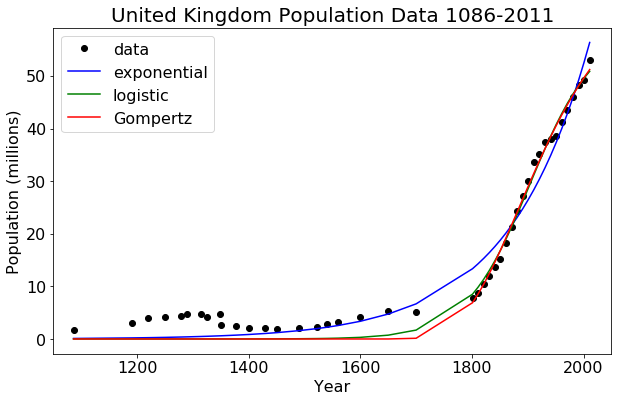

Adjusted Exp R2 =  0.96224048353
Adjusted Log R2 =  0.972209708613
Adjusted Gomp R2 =  0.970751354525

Exp P0 = 56.3525786156
 Exp r = 0.00685814162951

Log P0 = 50.8621953843
 Log r = 0.0172548560417
 Log L = 58.9028161298

Gom P0 = 51.2019847029
 Gom r = 0.00988342841502
 Gom L = 68.2828884314
 

For the following values of 2011, I eliminated the data point for 2011 and recalculated the models
for that year. The values were then compared by using the error function:

 Exponential 
Exponential estimation for 2011: 57.7
Error from actual value of 2011: 8.78%

 Logistic 
   Logistic estimation for 2010: 49.6
Error from actual value of 2010: 6.52%

 Gompertz 
   Gompertz estimation for 2010: 50.2
Error from actual value of 2010: 5.21%


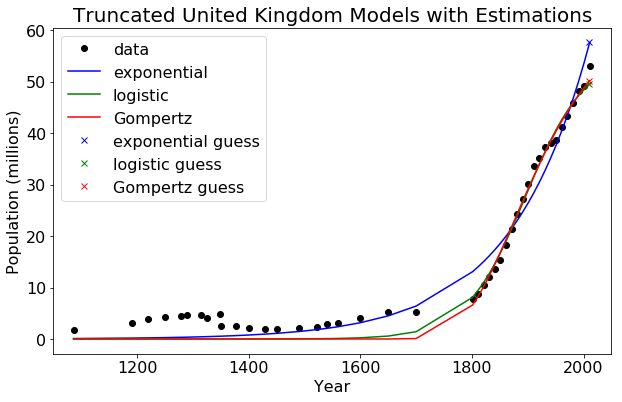

In [27]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#This class can be called to alter the text of a printed line
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


#--------------------------------------------------
# Read and scale US Population Data. From: https://en.wikipedia.org/wiki/Demography_of_England
#--------------------------------------------------
CensusFile = open('UKPopulation.csv', 'r') #Don't you dare overwrite this file!
N = 43 # number of data points
i = 0
j = 0
UKYears = np.zeros([N], dtype=int)
UKPop0 = np.zeros([N], dtype=int)
for line in CensusFile:
    if i == 0 or i==1:
        i=i+1
    else:
        values = line.split(',')
        UKYears[j] = int(values[0])
        UKPop0[j] = int(values[1])
        j = j+1
        i = i+1

CensusFile.close()
UKPop = UKPop0/1.e6 #population as a floating point number in millions

#------------------------------------------------------------------------------------------
# Time to make the functions of our models
#------------------------------------------------------------------------------------------

#Exponential model
def UK_exp(t,P0,r):
    P = P0*np.exp(r*t)
    return P

#Logistic Model
def UK_log(t,P0,r,L):
    A = ((L-P0)/P0)
    T = L
    B = 1 + A*np.exp(-r*t)
    return T/B

#Gompertz Model
def UK_Gomp(t,P0,r,L):
    rG = np.exp(-r*t)
    log = np.log(L/P0)
    exp = -log*rG
    return L*np.exp(exp)

#---------------------------------
# Population graph
#---------------------------------

#plt.figure(figsize=(8,6))
#plt.rc('xtick', labelsize=16) 
#plt.rc('ytick', labelsize=16)
#
#plt.plot(UKYears, UKPop, 'o', color=('r'), label='data')
#plt.ylabel('Population (millions)', fontsize=16)
#plt.xlabel('Year', fontsize=16)
#plt.title('United Kingdom Population Data 1086-2011', fontsize=20)
#plt.legend(loc=2, fontsize=16)
#plt.xlim([1000, 2050])
#plt.savefig('UKPopData.png')
#plt.show()
#plt.close()


#----- Estimating the upper limit of the population, L ---------
L = 100

#----------------------
# Optimize Exponential
#----------------------

#------- Approximate parameter values for Exponential model ------
a,b = np.polyfit(UKYears-2011,np.log(UKPop),1)
#print "a =", a,"b =", b

r_exp_lin = a
P0_exp_lin = np.exp(b)
#print "r, P0 = ",r_exp_lin, P0_exp_lin

#------- Take estimate and create the model -------------

eopt, ecov = curve_fit(UK_exp, UKYears-2011, UKPop, p0=(P0_exp_lin,r_exp_lin))
#print "popt =", popt, "pcov =", pcov

P_0exp = eopt[0]
r_exp = eopt[1]
P_exp = UK_exp(UKYears-2011, P_0exp, r_exp)

#print "p_exp =", P_exp
#print UKPop

#----------------------
# Optimize Logistic
#----------------------

#------- Approximate paramater values for Logistic model ---------
c,d = np.polyfit(UKYears-2011, np.log((L/UKPop)-1),1)

#print "c = ",c
#print "d = ",d

r_log_lin = -c
P0_log_lin = L/(np.exp(d)+1)


#------- Take estimate and create logistic
lopt, lcov = curve_fit(UK_log, UKYears-2011, UKPop, p0=(P0_log_lin,r_log_lin,L))
#print "lopt =", lopt, "lcov =", lcov

P_0log = lopt[0]
r_log = lopt[1]
L_log = lopt[2]
P_log = UK_log(UKYears-2011, P_0log, r_log, L_log)

#print "P0 =", P_0log, "rlog", r_log, "Llog", L_log
#print ""
#print "lopt = ", lopt

#----------------------
# Optimize Gompertz
#----------------------

#------- Approximate parameter values for Gompertz model -----------
e,f = np.polyfit(UKYears-2011,np.log(np.log(L/UKPop)),1)

r_gomp_lin = -e
P_0gomp_lin = L*(np.exp(-np.exp(f)))

#print ("r_gom_lin =", r_gom_lin)
#print ("P_0gom_lin =", P_0gom_lin)

#------- Take estimate and create Gompertz --------
gopt, gcov = curve_fit(UK_Gomp, UKYears-2011, UKPop, p0=(P_0gomp_lin, r_gomp_lin,L))
#print "gopt =", gopt
#print "gcov =", gcov

P_0gomp = gopt[0]
r_gomp = gopt[1]
L_gomp = gopt[2]
P_gomp = UK_Gomp(UKYears-2011, P_0gomp, r_gomp, L_gomp) 

#------------------------
# Plotting the Graphs
#------------------------

plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
#Plotting the data points
plt.plot(UKYears, UKPop, 'o', color='k', label='data')
#First, draw the exponential model,
plt.plot(UKYears, P_exp, color='b', label='exponential')
#then the logistic model,
plt.plot(UKYears, P_log, color='g', label="logistic")
#and finally Gompertz model.
plt.plot(UKYears, P_gomp, color='r', label = 'Gompertz')
plt.ylabel('Population (millions)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('United Kingdom Population Data 1086-2011', fontsize=20)
plt.legend(loc=2, fontsize=16)
#plt.xlim([-250, 10])
plt.xlim([1050,2050])
plt.savefig('UKPopModel.png')
plt.show()
plt.close()

#-------------------------------------------------------------------
# Finding the Coefficients of Determination for these three models
#-------------------------------------------------------------------

#R squared (coefficient of determination) for Exponential
numsum = np.zeros([3])
densum = np.zeros([3])
for i in range(N): #For all of the data points
    for j in range(3): #For all three sets of data
        if j==0:
            numsum[j] = numsum[j] + (UKPop[i]-UK_exp(UKYears[i]-2011, P_0exp, r_exp))**2
            densum[j] = densum[j] + (UKPop[i]-np.average(UKPop))**2
        elif j==1:
            numsum[j] = numsum[j] + (UKPop[i]-UK_log(UKYears[i]-2011, P_0log, r_log,L_log))**2
            densum[j] = densum[j] + (UKPop[i]-np.average(UKPop))**2
        else:
            numsum[j] = numsum[j] + (UKPop[i]-UK_Gomp(UKYears[i]-2011, P_0gomp, r_gomp,L_gomp))**2
            densum[j] = densum[j] + (UKPop[i]-np.average(UKPop))**2
    
expR2 = 1 - (numsum[0]/densum[0])
logR2 = 1 - (numsum[1]/densum[1])
gompR2 = 1 - (numsum[2]/densum[2])
#print "expR2 = ", expR2
#print "logR2 = ", logR2
#print "gompR2 = ", gompR2

#Adjusted coefficients of determinations
expAR2 = 1. - (1. - expR2)*((23.-1.)/(23.-2.-1.))
logAR2 = 1. - (1. - logR2)*((23.-1.)/(23.-3.-1.))
gompAR2 = 1. - (1. - gompR2)*((23.-1.)/(23.-3.-1.))
print "Adjusted Exp R2 = ", expAR2
print "Adjusted Log R2 = ", logAR2
print "Adjusted Gomp R2 = ", gompAR2

# Print the values I need for my paper
print ""
print "Exp P0 =", P_0exp
print " Exp r =", r_exp
print ""
print "Log P0 =", P_0log
print " Log r =", r_log
print " Log L =", L_log
print ""
print "Gom P0 =", P_0gomp
print " Gom r =", r_gomp
print " Gom L =", L_gomp

#------------------------------------------------------------
# Working with predictions: Eliminating the last data point
#------------------------------------------------------------

print "",'\n',""
print "For the following values of 2011, I eliminated the data point for 2011 and recalculated the models"
print "for that year. The values were then compared by using the error function:"

UKPopPast = UKPop[0:N-1]
UKYearsPast = UKYears[0:N-1]

#--------------- Exponential Model -------------------
ep_opt, ep_cov = curve_fit(UK_exp, UKYearsPast-2001, UKPopPast, p0=(P0_exp_lin,r_exp_lin))
#print "popt =", popt, "pcov =", pcov

P_0exp_past = ep_opt[0]
r_exp_past = ep_opt[1]
P_exp_past = UK_exp(UKYears- 2001, P_0exp_past, r_exp_past)

exp_est_2011 = UK_exp(10, P_0exp_past, r_exp_past)
print ""
print color.BOLD, "Exponential", color.END
print "Exponential estimation for 2011:", round(exp_est_2011,1)
print "Error from actual value of 2011: {}%".format(round((np.absolute(exp_est_2011-UKPop[N-1])/UKPop[N-1])*100,2))

#---------------- Logistic Model ---------------------
lp_opt, lp_cov = curve_fit(UK_log, UKYearsPast-2001, UKPopPast, p0=(P_0log, r_log, L_log))
#print "lopt =", lopt, "lcov =", lcov

P_0log_past = lp_opt[0]
r_log_past = lp_opt[1]
L_log_past = lp_opt[2]
P_log_past = UK_log(UKYears-2001, P_0log_past, r_log_past, L_log_past)

log_est_2011 = UK_log(10, P_0log_past, r_log_past, L_log_past)
print ""
print color.BOLD, "Logistic", color.END
print "   Logistic estimation for 2010:", round(log_est_2011,1)
print "Error from actual value of 2010: {}%".format(round((np.absolute(log_est_2011-UKPop[N-1])/UKPop[N-1])*100,2))

#---------------- Gompertz Model ---------------------
gp_opt, gp_cov = curve_fit(UK_Gomp, UKYearsPast-2001, UKPopPast, p0=(P_0gomp, r_gomp, L_gomp))
#print "gopt =", gopt
#print "gcov =", gcov

P_0gomp_past = gp_opt[0]
r_gomp_past = gp_opt[1]
L_gomp_past = gp_opt[2]
P_gomp_past = UK_Gomp(UKYears-2001, P_0gomp_past, r_gomp_past, L_gomp_past) 

gomp_est_2011 = UK_Gomp(10, P_0gomp_past, r_gomp_past, L_gomp_past)
print ""
print color.BOLD, "Gompertz", color.END
print "   Gompertz estimation for 2010:", round(gomp_est_2011,1)
print "Error from actual value of 2010: {}%".format(round((np.absolute(gomp_est_2011-UKPop[N-1])/UKPop[N-1])*100,2))

#--------------------------------------------------------------
# Plotting the models with the omission, as well as predictions
#--------------------------------------------------------------

plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
#Plotting the data points
plt.plot(UKYears, UKPop, 'o', color='k', label='data')
#First, draw the exponential model,
plt.plot(UKYears, P_exp_past, color='b', label='exponential')
#then the logistic model,
plt.plot(UKYears, P_log_past, color='g', label="logistic")
#and finally Gompertz model.
plt.plot(UKYears, P_gomp_past, color='r', label = 'Gompertz')
# ----- The next three are all the predicted values for 2010 ----
plt.plot(2010, exp_est_2011, 'x', color='b', label='exponential guess')
plt.plot(2010, log_est_2011, 'x', color='g', label='logistic guess')
plt.plot(2010, gomp_est_2011, 'x', color='r', label='Gompertz guess')
#
plt.ylabel('Population (millions)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('Truncated United Kingdom Models with Estimations', fontsize=20)
plt.legend(loc=2, fontsize=16)
#plt.xlim([-250, 10])
plt.xlim([1050, 2050])
plt.savefig('UKPopLOO.png')
plt.show()
plt.close()

